# Métodos de Clasificación Ordinal

### Evangelina Garza Elizondo
### Ciencia de Datos
### CIMAT, Monterrey

In [12]:
from __future__ import print_function
import numpy as np
import pandas as pd
import os
from sklearn import metrics
from scipy import linalg, optimize, sparse
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Funciones a utilizar

In [2]:
 """
    Las siguientes funciones calcula los parametros w,theta (coeficientes y
    cortes, respectivamente) de una regresión
    logística ordinal a partir de la optimización de la función de máxima
    verosímilitud. Esta función fue desarrollada por Fabian Pedregosa y está
    publicada en:
    https://github.com/fabianp/minirank/blob/master/minirank/logistic.py
    """
BIG = 1e10
SMALL = 1e-12

def phi(t):
    """
    logistic function, returns 1 / (1 + exp(-t))
    """
    idx = t > 0
    out = np.empty(t.size, dtype=np.float)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def log_logistic(t):
    """
    (minus) logistic loss function, returns log(1 / (1 + exp(-t)))
    """
    idx = t > 0
    out = np.zeros_like(t)
    out[idx] = np.log(1 + np.exp(-t[idx]))
    out[~idx] = (-t[~idx] + np.log(1 + np.exp(t[~idx])))
    return out


def ordinal_logistic_fit(X, y, alpha=0, l1_ratio=0, n_class=None, max_iter=10000,
                         verbose=False, solver='TNC', w0=None):
    X = np.asarray(X)
    y = np.asarray(y)
    w0 = None

    if not X.shape[0] == y.shape[0]:
        raise ValueError('Wrong shape for X and y')

    # .. order input ..
    idx = np.argsort(y)
    idx_inv = np.zeros_like(idx)
    idx_inv[idx] = np.arange(idx.size)
    X = X[idx]
    y = y[idx].astype(np.int)
    # make them continuous and start at zero
    unique_y = np.unique(y)
    for i, u in enumerate(unique_y):
        y[y == u] = i
    unique_y = np.unique(y)

    # .. utility arrays used in f_grad ..
    alpha = 0.
    k1 = np.sum(y == unique_y[0])
    E0 = (y[:, np.newaxis] == np.unique(y)).astype(np.int)
    E1 = np.roll(E0, -1, axis=-1)
    E1[:, -1] = 0.
    E0, E1 = map(sparse.csr_matrix, (E0.T, E1.T))

    def f_obj(x0, X, y):
        """
        Objective function
        """
        w, theta_0 = np.split(x0, [X.shape[1]])
        theta_1 = np.roll(theta_0, 1)
        t0 = theta_0[y]
        z = np.diff(theta_0)

        Xw = X.dot(w)
        a = t0 - Xw
        b = t0[k1:] - X[k1:].dot(w)
        c = (theta_1 - theta_0)[y][k1:]

        if np.any(c > 0):
            return BIG

        #loss = -(c[idx] + np.log(np.exp(-c[idx]) - 1)).sum()
        loss = -np.log(1 - np.exp(c)).sum()

        loss += b.sum() + log_logistic(b).sum() \
            + log_logistic(a).sum() \
            + .5 * alpha * w.dot(w) - np.log(z).sum()  # penalty
        if np.isnan(loss):
            pass
            #import ipdb; ipdb.set_trace()
        return loss

    def f_grad(x0, X, y):
        """
        Gradient of the objective function
        """
        w, theta_0 = np.split(x0, [X.shape[1]])
        theta_1 = np.roll(theta_0, 1)
        t0 = theta_0[y]
        t1 = theta_1[y]
        z = np.diff(theta_0)

        Xw = X.dot(w)
        a = t0 - Xw
        b = t0[k1:] - X[k1:].dot(w)
        c = (theta_1 - theta_0)[y][k1:]

        # gradient for w
        phi_a = phi(a)
        phi_b = phi(b)
        grad_w = -X[k1:].T.dot(phi_b) + X.T.dot(1 - phi_a) + alpha * w

        # gradient for theta
        idx = c > 0
        tmp = np.empty_like(c)
        tmp[idx] = 1. / (np.exp(-c[idx]) - 1)
        tmp[~idx] = np.exp(c[~idx]) / (1 - np.exp(c[~idx])) # should not need
        grad_theta = (E1 - E0)[:, k1:].dot(tmp) \
            + E0[:, k1:].dot(phi_b) - E0.dot(1 - phi_a)

        grad_theta[:-1] += 1. / np.diff(theta_0)
        grad_theta[1:] -= 1. / np.diff(theta_0)
        out = np.concatenate((grad_w, grad_theta))
        return out

    def f_hess(x0, s, X, y):
        x0 = np.asarray(x0)
        w, theta_0 = np.split(x0, [X.shape[1]])
        theta_1 = np.roll(theta_0, 1)
        t0 = theta_0[y]
        t1 = theta_1[y]
        z = np.diff(theta_0)

        Xw = X.dot(w)
        a = t0 - Xw
        b = t0[k1:] - X[k1:].dot(w)
        c = (theta_1 - theta_0)[y][k1:]

        D = np.diag(phi(a) * (1 - phi(a)))
        D_= np.diag(phi(b) * (1 - phi(b)))
        D1 = np.diag(np.exp(-c) / (np.exp(-c) - 1) ** 2)
        Ex = (E1 - E0)[:, k1:].toarray()
        Ex0 = E0.toarray()
        H_A = X[k1:].T.dot(D_).dot(X[k1:]) + X.T.dot(D).dot(X)
        H_C = - X[k1:].T.dot(D_).dot(E0[:, k1:].T.toarray()) \
            - X.T.dot(D).dot(E0.T.toarray())
        H_B = Ex.dot(D1).dot(Ex.T) + Ex0[:, k1:].dot(D_).dot(Ex0[:, k1:].T) \
            - Ex0.dot(D).dot(Ex0.T)

        p_w = H_A.shape[0]
        tmp0 = H_A.dot(s[:p_w]) + H_C.dot(s[p_w:])
        tmp1 = H_C.T.dot(s[:p_w]) + H_B.dot(s[p_w:])
        return np.concatenate((tmp0, tmp1))

        import ipdb; ipdb.set_trace()
        import pylab as pl
        pl.matshow(H_B)
        pl.colorbar()
        pl.title('True')
        import numdifftools as nd
        Hess = nd.Hessian(lambda x: f_obj(x, X, y))
        H = Hess(x0)
        pl.matshow(H[H_A.shape[0]:, H_A.shape[0]:])
        #pl.matshow()
        pl.title('estimated')
        pl.colorbar()
        pl.show()


    def grad_hess(x0, X, y):
        grad = f_grad(x0, X, y)
        hess = lambda x: f_hess(x0, x, X, y)
        return grad, hess

    x0 = np.random.randn(X.shape[1] + unique_y.size) / X.shape[1]
    if w0 is not None:
        x0[:X.shape[1]] = w0
    else:
        x0[:X.shape[1]] = 0.
    x0[X.shape[1]:] = np.sort(unique_y.size * np.random.rand(unique_y.size))

    #print('Check grad: %s' % optimize.check_grad(f_obj, f_grad, x0, X, y))
    #print(optimize.approx_fprime(x0, f_obj, 1e-6, X, y))
    #print(f_grad(x0, X, y))
    #print(optimize.approx_fprime(x0, f_obj, 1e-6, X, y) - f_grad(x0, X, y))
    #import ipdb; ipdb.set_trace()

    def callback(x0):
        x0 = np.asarray(x0)
        # print('Check grad: %s' % optimize.check_grad(f_obj, f_grad, x0, X, y))
        if verbose:
        # check that gradient is correctly computed
            print('OBJ: %s' % f_obj(x0, X, y))

    if solver == 'TRON':
        import pytron
        out = pytron.minimize(f_obj, grad_hess, x0, args=(X, y))
    else:
        options = {'maxiter' : max_iter, 'disp': 0, 'maxfun':10000}
        out = optimize.minimize(f_obj, x0, args=(X, y), method=solver,
            jac=f_grad, hessp=f_hess, options=options, callback=callback)

    #if not out.success:
        #warnings.warn(out.message)
    w, theta = np.split(out.x, [X.shape[1]])
    return w, theta

def ordinal_logistic_predict(w, theta, X):
    """
    Parameters
    ----------
    w : coefficients obtained by ordinal_logistic
    theta : thresholds
    """
    unique_theta = np.sort(np.unique(theta))
    out = X.dot(w)
    unique_theta[-1] = np.inf # p(y <= max_level) = 1
    tmp = out[:, None].repeat(unique_theta.size, axis=1)
    return np.argmax(tmp < unique_theta, axis=1)

In [3]:
class OrdinalClassifier():
    
    def __init__(self):
        pass
        
    def fit(self,X,y,sample_weight=None):
        ix=np.argsort(y)
        y=y[ix]
        X=X[ix]
        self.w,self.theta=ordinal_logistic_fit(X,y)
        self.uniq=np.unique(self.theta)
        return self
    
    def predict(self,X):
        y_new=np.zeros(X.shape[0])
        self.theta[-1]=np.infty
        
        for i in range(X.shape[0]):
            r=np.dot(self.w,X[i])
            
            if r<self.theta[-2]:
                tresh=np.where(r<self.theta)
                b=tresh[0][0]
                y_new[i]=b
            else:
                y_new[i]=self.uniq.shape[0]
        return y_new 
    
    def score(self,y1,y2):
        if y1.shape[0]==y2.shape[0]:
            error=0
            for i in range(y1.shape[0]):
                if y1[i]!=y2[i]:
                    error+=1
        else:
            print('Error de dimensiones de los arreglos')
        
        error=error/y1.shape[0]
        accsc=1-error
        return accsc       

## Conjuntos de Datos

#### College Application

In [4]:
X_pd=pd.read_stata('https://stats.idre.ucla.edu/stat/data/ologit.dta')
X_pd

,apply,pared,public,gpa
0,very likely,0,0,3.26
1,somewhat likely,1,0,3.21
2,unlikely,1,1,3.94
3,somewhat likely,0,0,2.81
4,somewhat likely,0,0,2.53
...,...,...,...,...
395,unlikely,0,0,3.70
396,unlikely,0,0,2.63
397,somewhat likely,0,0,2.25
398,somewhat likely,0,0,3.26


In [5]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
X_pd['code'] = LE.fit_transform(X_pd['apply'])
X_pd

,apply,pared,public,gpa,code
0,very likely,0,0,3.26,2
1,somewhat likely,1,0,3.21,0
2,unlikely,1,1,3.94,1
3,somewhat likely,0,0,2.81,0
4,somewhat likely,0,0,2.53,0
...,...,...,...,...,...
395,unlikely,0,0,3.70,1
396,unlikely,0,0,2.63,1
397,somewhat likely,0,0,2.25,0
398,somewhat likely,0,0,3.26,0


In [6]:
y=X_pd['code']
X_pd.drop(['apply'], axis = 'columns', inplace=True)
X_pd.drop(['code'], axis = 'columns', inplace=True)

In [7]:
X=X_pd.values
y=y.values

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(max_iter=10)

In [10]:
clf=OrdinalClassifier()

In [11]:
import mord as m

c = m.LogisticIT()

In [12]:
scores_ord=[]
scores_lr=[]
scores_mord=[]

for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)
    
    clf.fit(X_train,y_train)
    lr.fit(X_train,y_train)
    c.fit(X_train,y_train)
    y_ord=clf.predict(X_test)
    y_mord=c.predict(X_test)
    
    scores_ord.append(clf.score(y_ord,y_test))
    scores_lr.append(lr.score(X_test,y_test))
    scores_mord.append(c.score(X_test,y_test))

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method TNC does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: OptimizeWarning: Unknown solver options: maxfun
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method TNC does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: OptimizeWarning

In [13]:
d = {'Logistic Reg':scores_lr,'Ordinal Class': scores_ord, 'MORD': scores_mord}
Scores=pd.DataFrame(data=d)

In [14]:
Scores

,Logistic Reg,Ordinal Class,MORD
0,0.541667,0.525000,0.525000
1,0.583333,0.575000,0.575000
2,0.600000,0.566667,0.566667


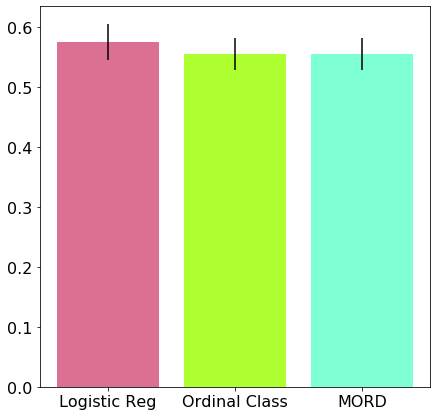

In [15]:
names = list(d.keys())
values = list(Scores.mean(axis=0))
errors = list(Scores.std(axis=0))
colors=['palevioletred','greenyellow','aquamarine','lightpink','coral','mediumorchid']

plt.figure(figsize=(7,7))
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.bar(names,values,yerr=errors,color=colors)
plt.show()

Text(0, 0.5, 'Accuracy Score')

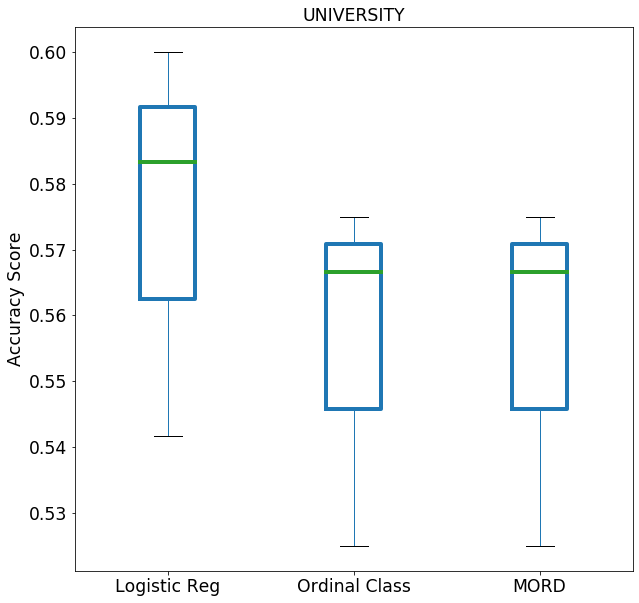

In [16]:
bp=Scores.boxplot(figsize=(10,10),fontsize='xx-large',
             boxprops=dict(linestyle='-', linewidth=4),
             medianprops=dict(linestyle='-', linewidth=4),grid=False)
bp.set_title('UNIVERSITY',fontsize='xx-large')
bp.set_ylabel('Accuracy Score',fontsize='xx-large')

#### Australian Open Statistics

In [17]:
X_pd=pd.read_csv('C:/Users/Evangelina Garza/Downloads/AusOpen-women-2013.csv')
y_pd=X_pd['FNL2']
X_pd=X_pd.dropna(axis='columns')
X_pd['FNL2']=y_pd
X_pd

,Player1,Player2,Round,Result,FSP.1,FSW.1,SSP.1,SSW.1,WNR.1,UFE.1,TPW.1,FSP.2,FSW.2,SSP.2,SSW.2,WNR.2,UFE.2,TPW.2,FNL2
0,Serena Williams,Ashleigh Barty,1,1,59,20,41,8,31,17,58,51,14,49,11,5,18,31,0.0
1,Vesna Dolonc,Lara Arruabarrena,1,1,65,33,35,10,7,4,78,62,33,38,10,0,3,74,1.0
2,Pauline Parmentier,Karolina Pliskova,1,0,63,16,37,4,3,6,37,60,26,40,7,5,0,64,2.0
3,Heather Watson,Daniela Hantuchova,1,0,61,41,39,19,27,45,88,68,43,32,10,37,44,102,2.0
4,Samantha Stosur,Klara Zakopalova,1,1,65,28,35,11,19,18,74,50,18,50,7,27,27,60,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,Simona Halep,Dominika Cibulkova,5,0,67,13,33,6,9,25,32,77,25,23,5,17,16,54,2.0
123,Agnieszka Radwanska,Victoria Azarenka,5,1,59,33,41,16,23,15,94,60,26,40,19,33,47,74,1.0
124,Eugenie Bouchard,Na Li,6,0,45,13,55,5,10,14,49,61,27,39,11,35,23,71,2.0
125,Dominika Cibulkova,Agnieszka Radwanska,6,1,64,22,36,10,21,20,63,68,17,32,2,12,24,40,0.0


In [18]:
X_pd=X_pd.dropna().copy()

In [19]:
y_pd=X_pd['FNL2']
X_pd.drop(['Player1'], axis = 'columns', inplace=True)
X_pd.drop(['Player2'], axis = 'columns', inplace=True)

In [20]:
X=X_pd.values
#X=X.astype(int)
y=y_pd.values
y=y.astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

In [22]:
scores_ord=[]
scores_lr=[]
scores_mord=[]

for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)
    
    clf.fit(X_train,y_train)
    lr.fit(X_train,y_train)
    c.fit(X_train,y_train)
    y_ord=clf.predict(X_test)
    y_mord=c.predict(X_test)
    
    scores_ord.append(clf.score(y_ord,y_test))
    scores_lr.append(lr.score(X_test,y_test))
    scores_mord.append(c.score(X_test,y_test))

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method TNC does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: OptimizeWarning: Unknown solver options: maxfun
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: 

In [23]:
d = {'Logistic Reg':scores_lr,'Ordinal Class': scores_ord, 'MORD': scores_mord}
Scores=pd.DataFrame(data=d)
Scores

,Logistic Reg,Ordinal Class,MORD
0,0.921053,0.500000,0.921053
1,0.947368,0.473684,0.842105
2,0.842105,0.421053,1.000000


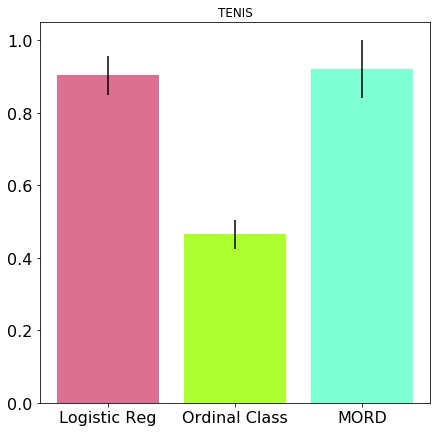

In [24]:
names = list(d.keys())
values = list(Scores.mean(axis=0))
errors = list(Scores.std(axis=0))
colors=['palevioletred','greenyellow','aquamarine','lightpink','coral','mediumorchid']

plt.figure(figsize=(7,7))
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.title('TENIS')
plt.bar(names,values,yerr=errors,color=colors)
plt.show()

Text(0, 0.5, 'Accuracy Score')

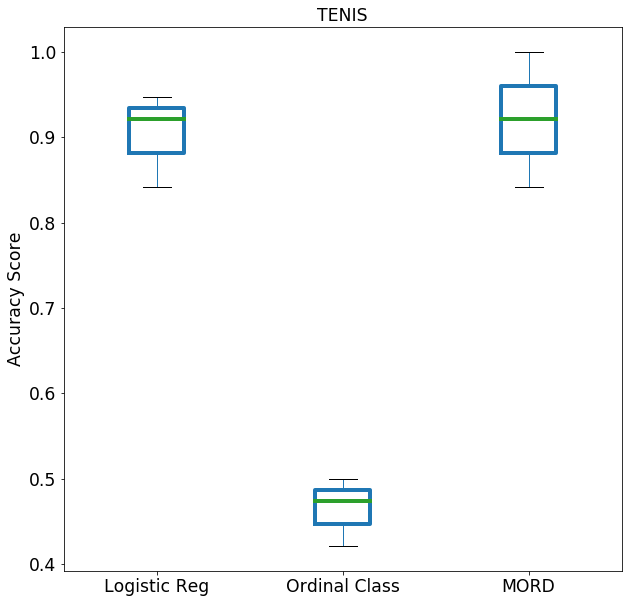

In [25]:
bp=Scores.boxplot(figsize=(10,10),fontsize='xx-large',
             boxprops=dict(linestyle='-', linewidth=4),
             medianprops=dict(linestyle='-', linewidth=4),grid=False)
bp.set_title('TENIS',fontsize='xx-large')
bp.set_ylabel('Accuracy Score',fontsize='xx-large')

#### CTG

In [13]:
X_pd=pd.read_csv('C:/Users/Evangelina Garza/Downloads/CTG.csv',sep=';')

In [14]:
y_pd=X_pd['NSP']

In [15]:
cols=['LB','AC','FM','UC','DL','DS','DP','ASTV','MSTV','ALTV','MLTV','Width','Min','Max','Nmax','Nzeros','Mode','Mean','Median','Variance','Tendency']
X_pd=X_pd.loc[:,cols]

In [16]:
X=X_pd.values
y=y_pd.values
y=y-1

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)

In [31]:
scores_ord=[]
scores_lr=[]
scores_mord=[]

for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)
    
    clf.fit(X_train,y_train)
    lr.fit(X_train,y_train)
    c.fit(X_train,y_train)
    y_ord=clf.predict(X_test)
    y_mord=c.predict(X_test)
    
    scores_ord.append(clf.score(y_ord,y_test))
    scores_lr.append(lr.score(X_test,y_test))
    scores_mord.append(c.score(X_test,y_test))

C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method TNC does not use Hessian-vector product information (hessp).
  'information (hessp).' % method, RuntimeWarning)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:199: OptimizeWarning: Unknown solver options: maxfun
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: 

In [32]:
d = {'Logistic Reg':scores_lr,'Ordinal Class': scores_ord, 'MORD': scores_mord}
Scores=pd.DataFrame(data=d)
Scores

,Logistic Reg,Ordinal Class,MORD
0,0.863636,0.793103,0.860502
1,0.851097,0.821317,0.873041
2,0.851097,0.783699,0.854232


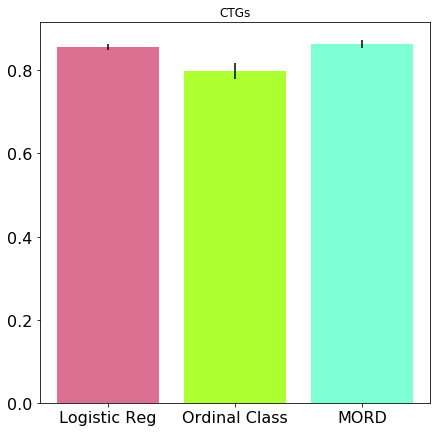

In [33]:
names = list(d.keys())
values = list(Scores.mean(axis=0))
errors = list(Scores.std(axis=0))
colors=['palevioletred','greenyellow','aquamarine','lightpink','coral','mediumorchid']

plt.figure(figsize=(7,7))
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.title('CTGs')
plt.bar(names,values,yerr=errors,color=colors)
plt.show()

Text(0, 0.5, 'Accuracy Score')

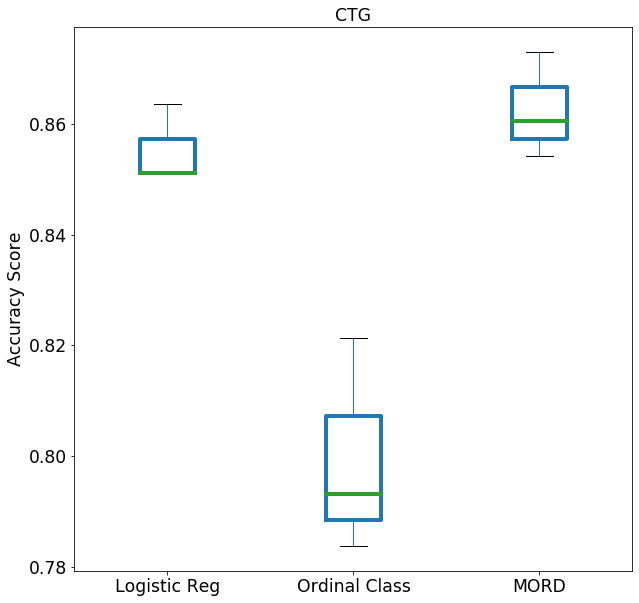

In [34]:
bp=Scores.boxplot(figsize=(10,10),fontsize='xx-large',
             boxprops=dict(linestyle='-', linewidth=4),
             medianprops=dict(linestyle='-', linewidth=4),grid=False)
bp.set_title('CTG',fontsize='xx-large')
bp.set_ylabel('Accuracy Score',fontsize='xx-large')

## Adaptación de un Clasificador

In [18]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)

In [19]:
def ordinal_adaptation(clf,X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)
    
    n=y.shape[0]
    n_train=y_train.shape[0]
    n_test=y_test.shape[0]
    
    clases=np.unique(y)
    n_splits=clases.shape[0]-1
    
    y_bin=np.zeros((n_test,n_splits))
    Y_m=np.zeros(n_test)

    for j in range(n_splits):
        y_r=np.zeros(y_train.shape[0])
        for i in range(y_train.shape[0]):
            if y_train[i]<=clases[j]:
                y_r[i]=1
            else:
                y_r[i]=2
    
        clf.fit(X_train,y_r)
        y_bin[:,j]=clf.predict(X_test)

    for i in range(n_test):
        if n_splits>=3:
            temp=y_bin[i,]
            temp=temp.astype(int)
            counts=np.bincount(temp)
            Y_m[i]=np.argmax(counts)
        else:
            if y_bin[i,0]==y_bin[i,1]:
                if y_bin[i,0]==1:
                    Y_m[i]=0
                elif y_bin[i,0]==2:
                    Y_m[i]=2
            else:
                Y_m[i]=1
    
    error=0
    for i in range(y_test.shape[0]):
        if y_test[i]!= Y_m[i]:
            error+=1
    error=error/y_test.shape[0]
    score=1-error
        
    return Y_m,y_test,score

In [20]:
ctree_ord=[]
ctree_reg=[]

for i in range(3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True)
    Y,y_t,score=ordinal_adaptation(clf,X,y)
    
    clf.fit(X_train,y_train)
    y_ctree=clf.predict(X_test)
    
    ctree_ord.append(score)
    ctree_reg.append(clf.score(X_test,y_test))

In [21]:
d = {'Ctree Reg':ctree_reg,'CTree Ordinal': ctree_ord}
Scores=pd.DataFrame(data=d)
Scores

,Ctree Reg,CTree Ordinal
0,0.918495,0.926332
1,0.916928,0.934169
2,0.920063,0.927900


In [22]:
Scores.mean()

Ctree Reg        0.918495
CTree Ordinal    0.929467
dtype: float64

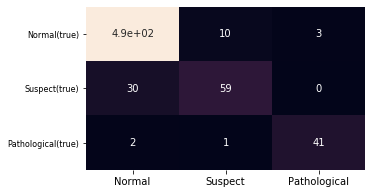

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm =confusion_matrix(y_t, Y)
cm_df = pd.DataFrame(cm)    

plt.figure(figsize=(5,3))
ax = sns.heatmap(cm_df, annot=True,yticklabels=['Normal(true)','Suspect(true)','Pathological(true)']
                 , xticklabels=['Normal','Suspect','Pathological'],cbar=False)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

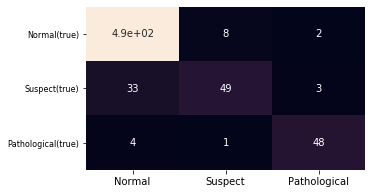

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm =confusion_matrix(y_test, y_ctree)
cm_df = pd.DataFrame(cm)    

plt.figure(figsize=(5,3))
ax = sns.heatmap(cm_df, annot=True,yticklabels=['Normal(true)','Suspect(true)','Pathological(true)']
                 , xticklabels=['Normal','Suspect','Pathological'],cbar=False)
ax.set_yticklabels(ax.get_yticklabels(), rotation = 0, fontsize = 8)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()